# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Cargar los datos
try:
    data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv("car_data.csv", index_col=[0], parse_dates=[0])

La columna `datetime`, se determina como tipo de valor datetime64 y se determina como el index de la tabla.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Se puede apreciar que solo tenemos dos columnas, el índice con fechas y horas; y la columna `num_orders` con el número de pedidos. La tabla cuenta con dos columnas con 26,496 renglones.

## Preparación

Se procederá a ordenar los datos por fecha y a agrupar los datos por hora.

In [5]:
#Se ordena la tabla por fecha
data.sort_index(inplace=True)

In [6]:
#Se agrupan los datos por hora
data = data.resample("1H").sum()

In [7]:
#Se crea variable que divide el df en tendencia, estacionalidad y residuo
decomposed = seasonal_decompose(data)


Se puede visualizar que los datos se ordenaron y agruparon de manera correcta. Los datos proporcionados por la compañía son relacionados desde el 1 de marzo hasta el 31 de agosto del 2018.

## Análisis

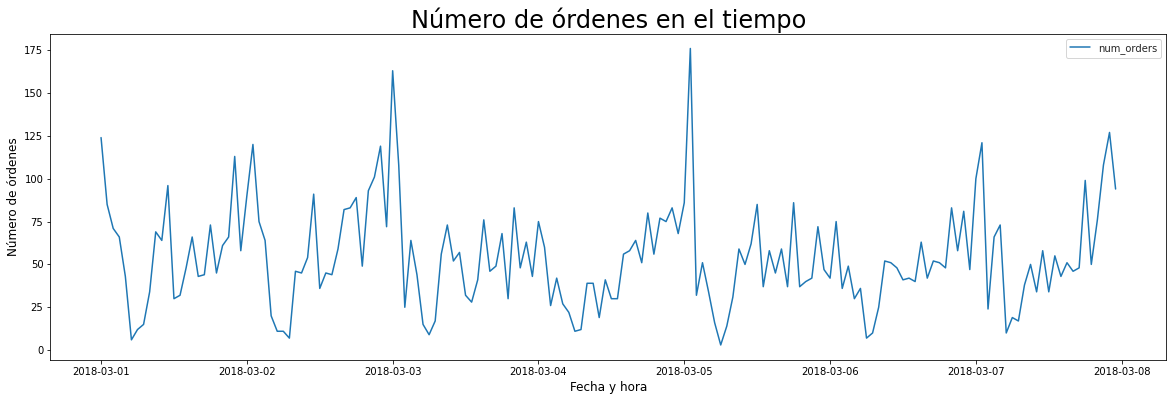

In [8]:
fig,ax =  plt.subplots(figsize = (20, 6))
sns.set_style("whitegrid")
sns.lineplot(data=data.loc["2018-03-01":"2018-03-07"], ax=ax)
ax.set_title("Número de órdenes en el tiempo" , size = 24 )
ax.set_xlabel("Fecha y hora", size = 12 )
ax.set_ylabel("Número de órdenes", size = 12 )
plt.show()


En este gráfico se analizan cuatro días del mes. Se puede apreciar como hay horas en las que aumenta significativamente el número de órdenes y luego cae drásticamente en ciertos horarios. 

A continuación, se realizará el calculo de la media movil para conocer en cual día de la semana impacta más la tendencia. Por consiguiente, la ventana de la media movil se establecerá en 7.

In [9]:
#Se crea columna de variable movil
data["num_orders_mean"] = data.rolling(7).mean()

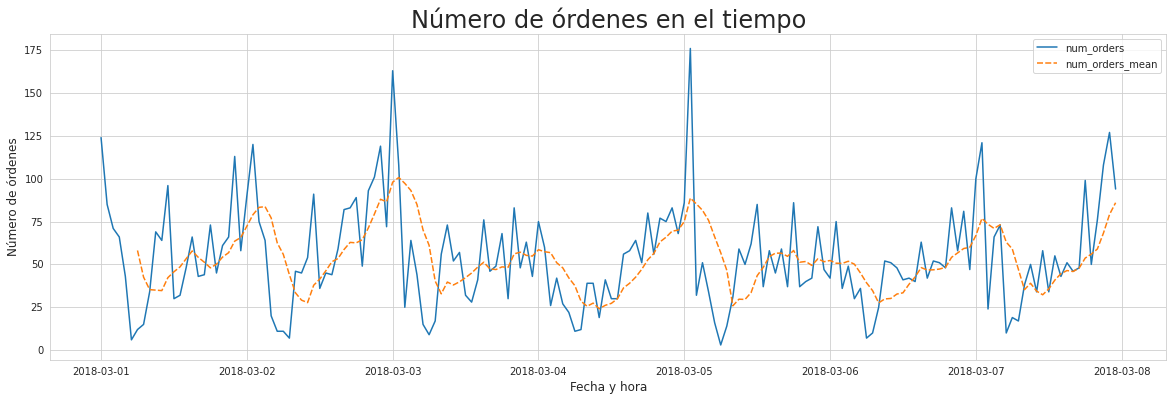

In [10]:
#Media movil
fig,ax =  plt.subplots(figsize = (20, 6))
sns.set_style("whitegrid")
sns.lineplot(data=data.loc["2018-03-01":"2018-03-07"], ax=ax)
ax.set_title("Número de órdenes en el tiempo" , size = 24 )
ax.set_xlabel("Fecha y hora", size = 12 )
ax.set_ylabel("Número de órdenes", size = 12 )
plt.show()

 La media movil de las órdenes, muestra de manera más drástica los cambios bruscos en el tiempo. Se puede notar el mayor pico entre la media noche y seis de la mañana.

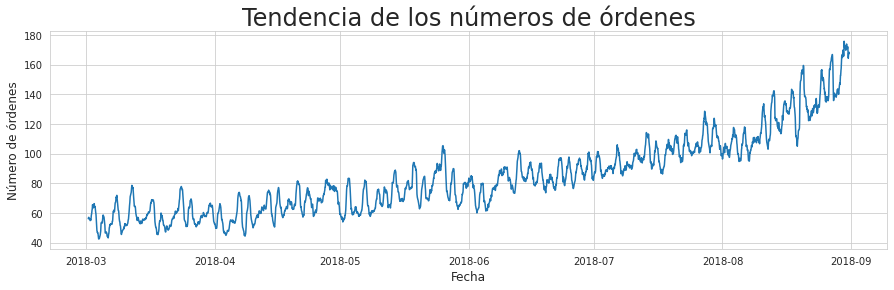

In [11]:
fig,ax =  plt.subplots(figsize = ( 15, 4))
sns.lineplot(data=decomposed.trend)
ax.set_title("Tendencia de los números de órdenes" , size = 24 )
ax.set_xlabel("Fecha", size = 12 )
ax.set_ylabel("Número de órdenes", size = 12 )
plt.show()

Se puede apreciar en el gráfico que la tendencia del número de órdenes va a la alta. Se realizará un suavizado para determinar si el crecimiento es lineal o exponencial.

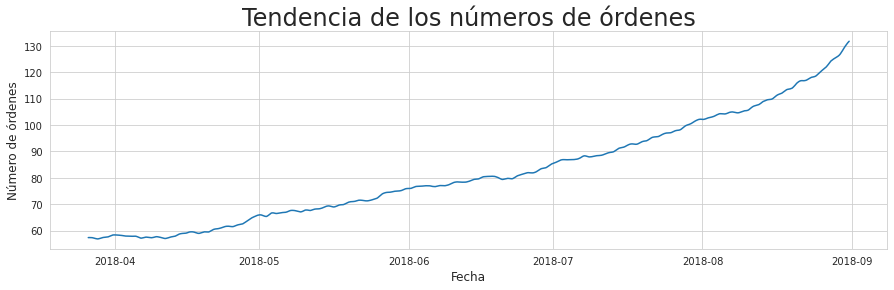

In [12]:
fig,ax =  plt.subplots(figsize = ( 15, 4))
sns.lineplot(data=decomposed.trend.rolling(600).mean())
ax.set_title("Tendencia de los números de órdenes" , size = 24 )
ax.set_xlabel("Fecha", size = 12 )
ax.set_ylabel("Número de órdenes", size = 12 )
plt.show()

Se puede notar una ligerá curvatura en el gráfico, lo cual se puede determinar un crecimiento no lineal, desde 60 hasta 180.

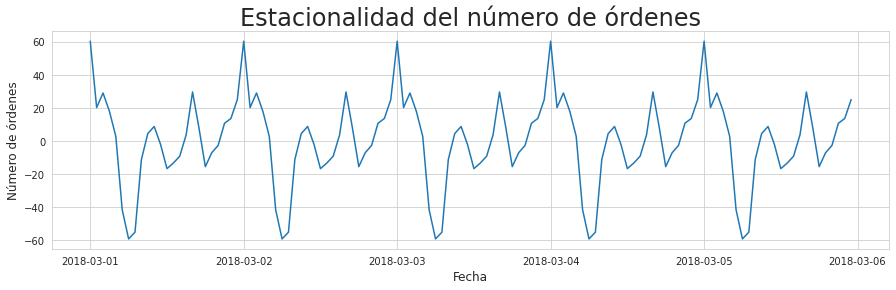

In [13]:
fig,ax =  plt.subplots(figsize = ( 15, 4))
sns.lineplot(data=decomposed.seasonal.loc["2018-03-01":"2018-03-05"])
ax.set_title("Estacionalidad del número de órdenes" , size = 24 )
ax.set_xlabel("Fecha", size = 12 )
ax.set_ylabel("Número de órdenes", size = 12 )
plt.show()

Como se había comentado anteriormente, al inicio de cada día, por la madrugada, hay un repunte de órdenes de taxi, que disminuyen y luego el ciclo comienza. Los valores oscilan entre -60 y 60.

In [14]:
#Comprobar decomposed
print(decomposed.trend[15:20] + decomposed.seasonal[15:20] + decomposed.resid[15:20])
print()
print(data[15:20]["num_orders"])

datetime
2018-03-01 15:00:00    66.0
2018-03-01 16:00:00    43.0
2018-03-01 17:00:00    44.0
2018-03-01 18:00:00    73.0
2018-03-01 19:00:00    45.0
Freq: H, dtype: float64

datetime
2018-03-01 15:00:00    66
2018-03-01 16:00:00    43
2018-03-01 17:00:00    44
2018-03-01 18:00:00    73
2018-03-01 19:00:00    45
Freq: H, Name: num_orders, dtype: int64


Se puede apreciar que la suma de los tres valores de decomposed dan como resultado el número de órdenes de la tabla original.

## Formación

A continuación se realizará la segmentación y creación de características. Para ello primero se eliminarán los valores ausentes que se generaron al crear la media movil de 7. Debido a que son los valores que mejor representan los cambios bruscos en el gráfico.

### Preparación de datos para el modelo

In [15]:
data = data.dropna()

In [16]:
#Se crean los conjuntos de entrenamiento, validación y test
(train, test)= train_test_split(data, shuffle=False, test_size=0.2)

(test, valid)= train_test_split(test, shuffle=False, test_size=0.5)

In [17]:
print(f"Número de filas del conjunto de datos train: "
      ,train.shape[0])
print(f"Rango", train.index.min(),"-",train.index.max())
print()
print(f"Número de filas del conjunto de datos test: "
      ,test.shape[0])
print(f"Rango", test.index.min(),"-",test.index.max())
print()
print(f"Número de filas del conjunto de datos valid: "
      ,valid.shape[0])
print(f"Rango", valid.index.min(),"-", valid.index.max())


Número de filas del conjunto de datos train:  3528
Rango 2018-03-01 06:00:00 - 2018-07-26 05:00:00

Número de filas del conjunto de datos test:  441
Rango 2018-07-26 06:00:00 - 2018-08-13 14:00:00

Número de filas del conjunto de datos valid:  441
Rango 2018-08-13 15:00:00 - 2018-08-31 23:00:00


Ahora se calculará el intervalo de tiempo entre el último dia del set de entranimiento y el último día del set de validación. Este tiempo será el desfase. 

In [18]:
test.index.max()-train.index.max()

Timedelta('18 days 09:00:00')

Esto equivale a 18 días con 9 horas, debido a que tenemos cada dato por hora. Esto equivaldría a:


In [19]:
print ("Predicción para:",18*24+18, "horas")

Predicción para: 450 horas


Idealmente la predicción debería ser para esa cantidad de horas, pero no tenemos suficiente datos para mostrarlo, por consiguiente se toma la decisión de predecir 100 horas.

In [20]:
def make_features(data, max_lag):
    """
    La función permite crear las caraterísticas para 
    el entrenamiento del modelo.
    data = en el que se crearán las características
    max:lag = cuantos valores de desfase se quiere crea
    rolling_mean_size = tamaño de ventana de la media movil
    """
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    

In [21]:
#Se aplica función
make_features(train, 100)
make_features(test, 100)
make_features(valid, 100)

/tmp/ipykernel_94/1734674919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data.index.year
/tmp/ipykernel_94/1734674919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data.index.month
/tmp/ipykernel_94/1734674919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [22]:
#Se eliminan los valores ausentes 
train = train.dropna()
test = test.dropna()
valid = valid.dropna()

Se crearon las características de manera correcta.

In [23]:
#Se crea la variable features
features_train = train.drop("num_orders", axis=1)
features_test = test.drop("num_orders", axis=1)
features_valid = valid.drop("num_orders", axis=1)

In [24]:
#Se crea la variable target
target_train = train["num_orders"]
target_test = test["num_orders"]
target_valid = valid["num_orders"]

### Modelo de Regresión Lineal

In [25]:
model = LinearRegression()  
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_test) 

recm_rl = mean_squared_error(target_test, predicted_valid) ** 0.5 #Se eleva a potencia 0.5 para obtener RECM

print("Raiz cuadrada del error cuadrático medio del conjunto de test:", 
      round(recm_rl, 2))



Raiz cuadrada del error cuadrático medio del conjunto de test: 0.0


El modelo de regresión lineal calculó un RECM de 0. El resultado es muy bueno, pero no quiere decir que sea correcto, es probable que este sobreentrenado el modelo.

### Modelo Random Forest Regressor

In [26]:
model = RandomForestRegressor(random_state=931106)
params = {
          'n_estimators': list(range(1, 10)),
          'max_depth': list(range(1, 20)),
          'max_features': [2, 3]
         }
         
clf = GridSearchCV(model, params, cv = 10, scoring='r2')
clf.fit(features_valid, target_valid)
print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 14, 'max_features': 3, 'n_estimators': 9}
0.4317628923092577


In [27]:
model = RandomForestRegressor(
                                random_state=931106, 
                                n_estimators= 9,
                                max_features=3,
                                max_depth= 14
                            ) 
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_test) 

recm_rf = mean_squared_error(target_test, predicted_valid) ** 0.5 #Se eleva a potencia 0.5 para obtener RECM

print("Raiz cuadrada del error cuadrático medio del conjunto de test:", 
      round(recm_rf, 2))

Raiz cuadrada del error cuadrático medio del conjunto de test: 36.49


El modelo de random forest regressor calculó un RECM de 36.49. El resultado del modelo es bastante satisfatorio.

### Modelo LightGBM

Se realizarán dos modelo, uno sin hiperparámetros y otro utilizando hiperaparámetros.

In [28]:
model = lgb.LGBMRegressor(random_state=931106)
params = [
            {'max_depth': list(range(1, 20))}
         ]
clf = GridSearchCV(model, params, cv = 10, scoring='r2')
clf.fit(features_valid, target_valid)
print(clf.best_params_)
print(clf.best_score_)


{'max_depth': 1}
0.5304817678862264


In [29]:
model = lgb.LGBMRegressor(
                        max_depth= 1, 
                        num_leaves=2**1, 
                        random_state=931106
                        )
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_test) 

recm_lgb = mean_squared_error(target_test, predicted_valid) ** 0.5 #Se eleva a potencia 0.5 para obtener RECM


print("Raiz cuadrada del error cuadrático medio del conjunto de test:", 
      round(recm_lgb, 2))


Raiz cuadrada del error cuadrático medio del conjunto de test: 34.45


El modelo de LGBM regressor calculó un RECM de 34.45. El resultado del modelo es bastante satisfatorio.

### Modelo CatBoost

In [30]:
model = CatBoostRegressor(random_state=931106, 
                          loss_function="RMSE", 
                          silent=True, 
                          iterations=100
                         )
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_test) 

recm_cb = mean_squared_error(target_test, predicted_valid) ** 0.5 #Se eleva a potencia 0.5 para obtener RECM


print("Raiz cuadrada del error cuadrático medio del conjunto de test:", 
      round(recm_cb, 2))


Raiz cuadrada del error cuadrático medio del conjunto de test: 28.03


El modelo de CatBoost calculó un RECM de 28.03. El resultado del modelo es bastante satisfatorio.

### Modelo XGboost

In [31]:
model = XGBRegressor(n_estimators = 100, random_state=931106)
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_test) 
recm_xgb = mean_squared_error(target_test, predicted_valid) ** 0.5 #Se eleva a potencia 0.5 para obtener RECM

print("Raiz cuadrada del error cuadrático medio del conjunto de test:", 
      round(recm_xgb, 2))


Raiz cuadrada del error cuadrático medio del conjunto de test: 29.7


El modelo de XGboost calculó un RECM de 32.48. El resultado del modelo es bastante satisfatorio.

## Conclusión

In [32]:
#Datos modelos
rl = ["Regresión lineal", recm_rl]
rf = ["Random Forest", recm_rf]
lgb = ["LightGBM", recm_lgb]
cb = ["CatBoost", recm_cb]
xgb = ["XGboost", recm_xgb]

In [33]:
#Lista
list_model = [rl, rf, lgb, cb, xgb]

In [34]:
#Se crea tabla con valores obtenidos
resume = pd.DataFrame(list_model,
                      columns = ["Nombre", "RECM"])

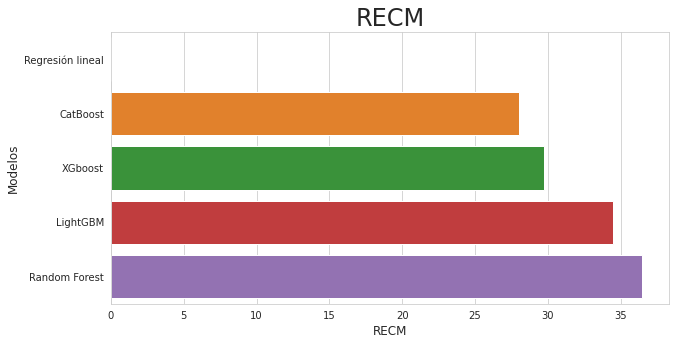

In [35]:
fig, ax = plt.subplots(figsize = (10, 5)) 
sns.barplot(data=resume.sort_values("RECM"),
            x="RECM", y="Nombre")
ax.set_title( "RECM" , size = 24 )
ax.set_xlabel( "RECM" , size = 12 )
ax.set_ylabel( "Modelos" , size = 12 )
plt.show()

In [36]:
resume.sort_values("RECM")

,Nombre,RECM
0,Regresión lineal,3.863441e-13
3,CatBoost,2.803492e+01
4,XGboost,2.970198e+01
2,LightGBM,3.444506e+01
1,Random Forest,3.648860e+01


En el analisis del de los datos se encontraron los siguientes hallazgos:
1. Hay una tendencia en un aumento en las órdene de taxi por la madrugada, entre media noche y de la mañana. Se demuestra que este comportamiento es estacional en todo en el tiempo.

2. Existe un incremento en el tiempo no lineal en el aumento de las órdenes de servicio.

3. Se pueda apreciar que el mejor modelo con mejor RECM fue la regresión lineal con casi 0. Luego le sigue el modelo CatBoos con un 28.03 y XGBoost con 29.70 de RECM. Los modelos con mayor RECM fueron LightGBM y Random Forest, pero entran dentro del rango de tolerancia.